In [1]:
import random, math, os, time
import sys; sys.path.append('..')
import pyzx as zx
import json
from pyzx_utils import json_to_graph

In [2]:
with open("C:\\Users\\valte\OneDrive - University of Helsinki\\Desktop\\zxlive\\test.json", "r") as f:
    jsonfile = json.load(f)
circuit = json_to_graph(jsonfile)

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\valte\AppData\Local\Temp\ipykernel_38212\4251945407.py:1: SyntaxWarning: invalid escape sequence '\O'
  with open("C:\\Users\\valte\OneDrive - University of Helsinki\\Desktop\\zxlive\\test.json", "r") as f:


In [5]:
zx.draw(circuit, labels=True)

print("Vertices: ", circuit.inputs())

Vertices:  [1, 2]


In [4]:
c1 = zx.extract_circuit(circuit.copy())
zx.draw(c1)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
def pretty_print_partial_order(order):
    ordered_order = sorted(order.items(), key=lambda x: x[1])
    print("Ordered partial order:", ordered_order)
    ordered_order2 = {}
    for i in ordered_order:
        if i[1] not in ordered_order2:
            ordered_order2[i[1]] = []
        ordered_order2[i[1]].append(i[0])
    res = ""
    for i in range(len(ordered_order2)):
        t = ",".join([str(i) for i in sorted(ordered_order2[i])])
        res += t + " < "
    return res[:-3]

In [ ]:
c = zx.qasm(
"""
// quantum teleportation minimal example
OPENQASM 2.0;
include "qelib1.inc";

// declarations, 3 qubits, 2 classical bits
qreg q[3];
cz q[0], q[1];
rz(pi*0.5) q[1];
cz q[1], q[2];
""")
#zx.draw(c)
g = c.to_graph()
#zx.full_reduce(g)
#g.normalize()
zx.draw(g, labels=True)
#print(zx.tcount(g))
order, gv = zx.gflow.gflow(g, pauli=True)
print("Gflow correction set:", gv)

print("Gflow partial order pretty print:", pretty_print_partial_order(order))

Gflow correction set: {3: {5, 7}, 5: {7}}
Ordered partial order: [(3, 0), (5, 0), (4, 1), (6, 1), (7, 1)]
Gflow partial order pretty print: 3,5 < 4,6,7


In [ ]:
g1 = g.copy()
#zx.todd.todd_on_graph(g1)
zx.spider_simp(g1)
zx.draw(g1)
i, j = zx.gflow.gflow(g1, pauli=True)

print("Gflow partial order pretty print:", pretty_print_partial_order(i))

Ordered partial order: [(3, 0), (4, 0), (6, 0)]
Gflow partial order pretty print: 3,4,6


In [ ]:
c1 = zx.extract_circuit(g1.copy())
zx.draw(c1)

In [ ]:
print(zx.gflow.gflow(g1, pauli=True))

({8: 2, 12: 2, 5: 2, 4: 1, 6: 1, 7: 1, 3: 0}, {4: {5}, 6: {8}, 7: {12}, 3: {4}})


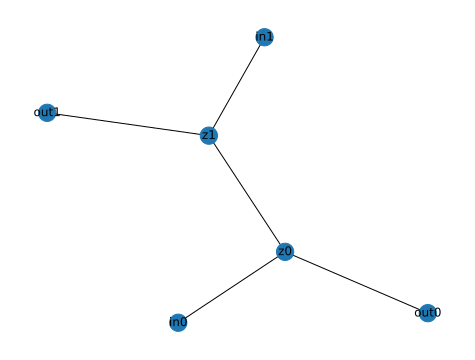

In [ ]:
import networkx as nx

# Create a new graph
G = nx.Graph()

# Add input and output nodes for 2 qubits
G.add_node('in0', is_input=True)
G.add_node('in1', is_input=True)
G.add_node('out0', is_output=True)
G.add_node('out1', is_output=True)

# Add Z spiders (green nodes) for each qubit
G.add_node('z0', type='Z', phase=0)
G.add_node('z1', type='Z', phase=0)

# Connect each input to its spider, and each spider to its output
G.add_edge('in0', 'z0', type='simple')
G.add_edge('in1', 'z1', type='simple')
G.add_edge('z0', 'out0', type='simple')
G.add_edge('z1', 'out1', type='simple')

# Add a Hadamard edge to z0 (this will become a Hadamard gate)
# For a Hadamard gate, you can represent it either as a self-loop or with an extra node.
# Here, let's just add a "hadamard" to the edge to the output.
G.add_edge('z0', 'out0', type='hadamard')

# Add a CNOT: Z spider on qubit 0 connected to Z spider on qubit 1
G.add_edge('z0', 'z1', type='simple')

# Now G is a simple ZX-graph for a 2-qubit circuit: H on qubit 0, then CNOT(0,1)

# Draw the graph
nx.draw(G, with_labels=True)

In [ ]:
import networkx as nx
from qiskit import QuantumCircuit

def extract_circuit_from_zx_graph(G: nx.Graph):
    """
    Simplified version of ZX-diagram circuit extraction.
    Input: G - a NetworkX graph representing a ZX-diagram.
    Output: Qiskit QuantumCircuit.
    """
    # 1. Identify input and output nodes
    input_nodes = [n for n, d in G.nodes(data=True) if d.get("is_input")]
    output_nodes = [n for n, d in G.nodes(data=True) if d.get("is_output")]

    n_qubits = len(output_nodes)
    qc = QuantumCircuit(n_qubits)

    # 2. Build initial "frontier": the neighbor of each output (excluding outputs)
    frontier = []
    wire_map = {}
    for i, out in enumerate(output_nodes):
        neighbors = [n for n in G.neighbors(out) if not G.nodes[n].get("is_output")]
        if neighbors:
            v = neighbors[0]
            frontier.append(v)
            wire_map[v] = i

    # 3. Main extraction loop
    while frontier:
        v = frontier.pop(0)
        vdata = G.nodes[v]
        q = wire_map[v]

        # 3a. Apply Hadamard if any incident edge is hadamard
        for neighbor in list(G.neighbors(v)):
            edata = G.get_edge_data(v, neighbor)
            if edata and edata.get("type") == "hadamard":
                qc.h(q)
                G.remove_edge(v, neighbor)

        # 3b. Apply phase if present
        phase = vdata.get("phase", 0)
        if phase != 0:
            if vdata.get("type") == "Z":
                qc.rz(phase, q)
            elif vdata.get("type") == "X":
                qc.rx(phase, q)
        
        # 3c. Check for 2-qubit connections (CNOT/CZ)
        for neighbor in list(G.neighbors(v)):
            if neighbor in wire_map:
                q2 = wire_map[neighbor]
                edata = G.get_edge_data(v, neighbor)
                if vdata.get("type") == "Z" and G.nodes[neighbor].get("type") == "X":
                    qc.cx(q, q2)
                elif vdata.get("type") == "Z" and G.nodes[neighbor].get("type") == "Z":
                    qc.cz(q, q2)
                elif vdata.get("type") == "X" and G.nodes[neighbor].get("type") == "X":
                    qc.cx(q, q2)  # For simplicity; real ZX may use XCX
                G.remove_edge(v, neighbor)

        # 3d. Remove node, update frontier
        for neighbor in list(G.neighbors(v)):
            if not G.nodes[neighbor].get("is_input") and neighbor not in frontier:
                frontier.append(neighbor)
                wire_map[neighbor] = q
        G.remove_node(v)

    # 4. Final swaps/Hadamards for correct output mapping (optional, not implemented here)
    return qc

In [ ]:
qiskit_circuit = extract_circuit_from_zx_graph(G)
print(qiskit_circuit)

     ┌───┐   
q_0: ┤ H ├─■─
     └───┘ │ 
q_1: ──────■─
             
